In [78]:
%pip install google-cloud-firestore
%pip install requests
%pip install pandas
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Parsing data

In [2]:
from google.cloud import firestore
from google.oauth2 import service_account
from datetime import datetime
import dateutil.parser
import requests

credentials = service_account.Credentials.from_service_account_file(
    'api-key.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

db = firestore.Client(
    credentials=credentials,
    project=credentials.project_id)

installation_ids = [8077, 1096, 10216, 9910, 58, 17, 9924, 2277, 820, 
                          8076, 9901, 9885, 9919, 2935, 9895, 9915, 9905, 8165, 
                          842, 9920, 2339, 1026, 9896, 9576, 9911, 7654, 2185, 
                          9897, 7661, 9888, 60, 9904, 2689, 7848, 10032, 9886, 
                          2743, 9890, 2903, 9899, 7514, 9906, 8973, 9921, 2098, 
                          7956, 9903, 9898, 9907, 7634, 9908, 3282, 9916, 9917, 
                          18, 9914, 9902, 9889, 9887, 7771, 9894, 5651, 2513, 
                          251, 7456, 9952, 237, 5624, 1029, 239, 59, 9892, 7617, 
                          1070, 627, 8979, 9912, 605, 6885, 9891, 8086, 247, 245, 
                          238, 7758, 9077, 7844, 233, 9913, 5625, 9923, 6070, 549, 
                          493, 6147, 241, 19, 5709, 7683, 708, 662, 7592, 9918, 347, 
                          7915, 9909, 6068, 6646, 6387, 7554, 329, 8017, 512, 246, 
                          236, 491, 7068, 8152, 7467, 7768, 1033, 10051, 7584, 7917, 
                          541, 7385, 397, 2274, 642, 5649, 301, 353, 5759, 423, 354, 
                          1092, 2123, 9996, 2467, 7656, 7427, 811, 335, 9922, 482, 
                          2440, 8983, 7673, 7386, 6076, 7685, 7383, 6643, 2849, 8981, 
                          7055, 883, 244, 931, 320, 492, 64, 323, 304, 521, 6381, 2832, 
                          9008, 327, 248, 366, 503, 7012, 7850, 349, 8126, 2827, 7872, 
                          615, 8082, 2066, 207, 620, 326, 413, 274, 2707, 2436, 473, 
                          5763, 6887, 7053, 7920, 2545, 2599, 3372, 332, 6116, 7566, 
                          7912, 350, 318, 7384, 514, 2869, 2655, 527, 3071, 6628, 2739, 
                          9946, 9106, 290, 7057, 5761, 2158, 2662, 291, 6095, 2554, 6649, 
                          7458, 6891, 6072, 2651, 8816, 6456, 317, 2975, 784, 7051, 7413, 
                          429, 2383, 810, 877, 8124, 7460, 5707, 388, 7049, 2419, 8157, 677, 
                          516, 7070, 8154, 2581, 314, 7687, 2090, 2872, 2454, 6093, 6893, 
                          296, 312, 7580, 313, 7983, 2619]


In [2]:
import pickle

def serialize(obj, name):
    with open(name, "wb") as file:
        pickle.dump(obj, file)
        file.flush()
        
def deserialize(name):
    with open(name, "rb") as file:
        return pickle.load(file)

## Get installation locations

In [7]:
import time

def get_location(inst_id):
    response_raw = requests.get('https://airapi.airly.eu/v2/installations/{}'.format(inst_id), 
                 headers={'Accept': 'application/json', 
                          'apikey': '<AIRY_API_KEY_HERE>'})
    if(response_raw.status_code is not 200):
        print(response_raw.json(), response_raw.status_code)
        return
    
    response = response_raw.json()
    
    if response is not None:
        latitude = response['location']['latitude'] if 'location' in response else None
        longitude = response['location']['longitude'] if 'location' in response else None
        elevation = response['elevation'] if 'elevation' in response else None
        city = response['address']['city'] if 'address' in response else None
        is_krakow = "Kraków" in city if city is not None else None
        return {
            'latitude': latitude,
            'longitude': longitude,
            'city': city,
            'elevation': elevation,
            'is_krakow': is_krakow
        }
    else:
        None

def parse_locations(ids = None):
    locations = {}
    for inst_id in installation_ids:
        locations[inst_id] = get_location(inst_id)
        time.sleep(1)
    return locations

locations = parse_locations()

{'errorCode': 'INSTALLATION_NOT_FOUND', 'message': 'Installation was not found', 'details': {'installationId': 2440}} 404


## Parse measurements

In [3]:
def parse_installations_remote(ids = None):
    installations = list(db.collection('installations').list_documents())
    installations_flat = {}

    for installation in installations:
        inst_id = int(installation.id.replace("_", ""))
        if ids is None or inst_id in ids:
            measurements = installation.collection('measurements').stream()
            measurements_flat = {}
            for measurement in measurements:
                for record in measurement.to_dict()['history']:
                    date = dateutil.parser.parse(record['fromDateTime'])
                    measurements_flat[date] = record
            installations_flat[inst_id] = {
                'measurements': measurements_flat,
                'location': locations[inst_id] if inst_id in locations else None
            }
    serialize(installations_flat, "installations.dat")
    return installations_flat

def parse_installations_local(ids = None):
    installations = deserialize("installations.dat")
    if ids is None:
        return installations
    return { key: installations[key] for key in ids }

def parse_installations(ids = None, local = True):
    return parse_installations_local(ids) if local else parse_installations_remote(ids)
        
installations = parse_installations(None, True)

## Parse weather

In [4]:
def parse_weather_remote(ids = None):
    weather_installations = list(db.collection('installations').list_documents())
    installations_flat = {}
    for installation in weather_installations:
        inst_id = int(installation.id.replace("_", ""))
        if ids is None or inst_id in ids:
            installations_flat[inst_id] = []
            weather = installation.collection("weather").stream()
            for weather_record in weather:
                dic_rec = weather_record.to_dict()
                parsed_rec = {}
                parsed_rec['time'] = datetime.fromtimestamp(dic_rec['dt'])
                parsed_rec['wind'] = dic_rec['wind']
                parsed_rec['sunset'] = datetime.fromtimestamp(dic_rec['sys']['sunset'])
                parsed_rec['sunrise'] = datetime.fromtimestamp(dic_rec['sys']['sunrise'])
                installations_flat[inst_id].append(parsed_rec)
    serialize(installations_flat, "weather.dat")
    return installations_flat

def parse_weather_local(ids = None):
    weather_dat = deserialize("weather.dat")
    if ids is None:
        return weather_dat
    return { key: weather_dat[key] for key in ids }

def parse_weather(ids = None, local = True):
    return parse_weather_local(ids) if local else parse_weather_remote(ids)

                           
weather_data = parse_weather(None, True)

## Merge weather with measurements

In [6]:
from datetime import timedelta
import pytz

def merge_weather_with_measurements(weather, measurements):
    for (inst_id, inst) in weather.items():
        sorted_weather_data = sorted(inst, key=lambda rec: rec['time'])
        for (date, values) in measurements[inst_id]['measurements'].items():
            nearest_weather_rec = None
            nearest_weather_time_diff = timedelta(seconds=99999999)
            for rec in sorted_weather_data:
                diff = date - rec['time'].replace(tzinfo=pytz.UTC)
                if abs(diff) < timedelta(minutes=120) and abs(diff) < nearest_weather_time_diff:
                    nearest_weather_time_diff = diff
                    nearest_weather_rec = rec
            values['weather'] = nearest_weather_rec
            
merge_weather_with_measurements(weather_data, installations)

## Add day/night label

In [24]:
def add_weather_label(installations):
    for (inst_id, inst) in installations.items():
        for (date, measurement) in inst['measurements'].items():
            weather = measurement['weather']
            if (weather is not None 
                and weather['sunset'].replace(tzinfo=pytz.UTC) >= date 
                and weather['sunrise'].replace(tzinfo=pytz.UTC) <= date):
                measurement['is_day'] = True
            else:
                measurement['is_day'] = False

add_weather_label(installations)

In [25]:
serialize(installations, "installations_weather.dat")

# Understanding data - plotting single installation metrics in given range

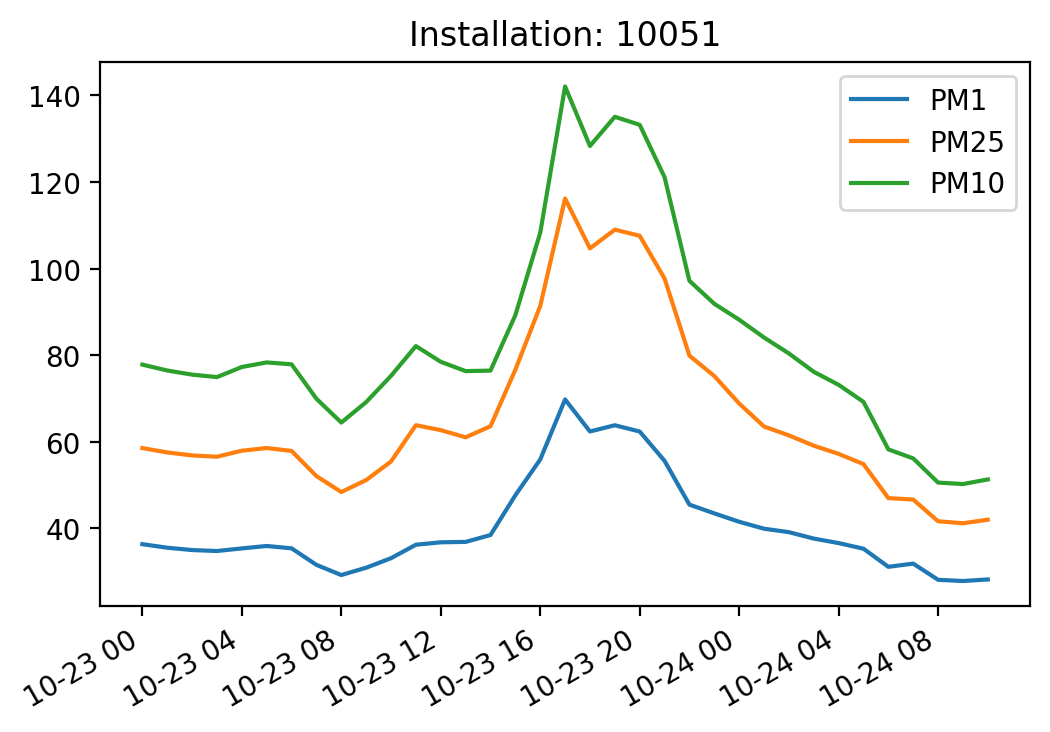

In [8]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import dates as dat
from datetime import datetime, timezone
import numpy as np

plt.rcParams['figure.dpi'] = 200

def plot_metrics_for_installation(installations, installation_id, metrics, start=None, end=None):
    datetimes = []
    values = {}
    for (key, value) in sorted(installations[installation_id]['measurements'].items(), key=lambda k: k[0]):
        if set(metrics).issubset(set(map(lambda val: val['name'], value['values']))):
            if (start is None or start <= key) and (end is None or end >= key):
                datetimes.append(key)
                for v in value['values']:
                    if v['name'] in metrics:
                        val_list = values.get(v['name'], [])
                        val_list.append(v['value']) 
                        values[v['name']] = val_list

    for (key, serie) in values.items():
        plt.plot(datetimes, serie, label=key)

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('Installation: {}'.format(installation_id))
    plt.show()

start_date = datetime(2019, 10, 23, 0, 0, 0, tzinfo=timezone.utc)
end_date = datetime(2019, 10, 24, 10, 0, 0, tzinfo=timezone.utc)
plot_metrics_for_installation(installations, 10051, ['PM1', 'PM10', 'PM25'], start_date, end_date)

# Understanding data - plotting averaged metrics

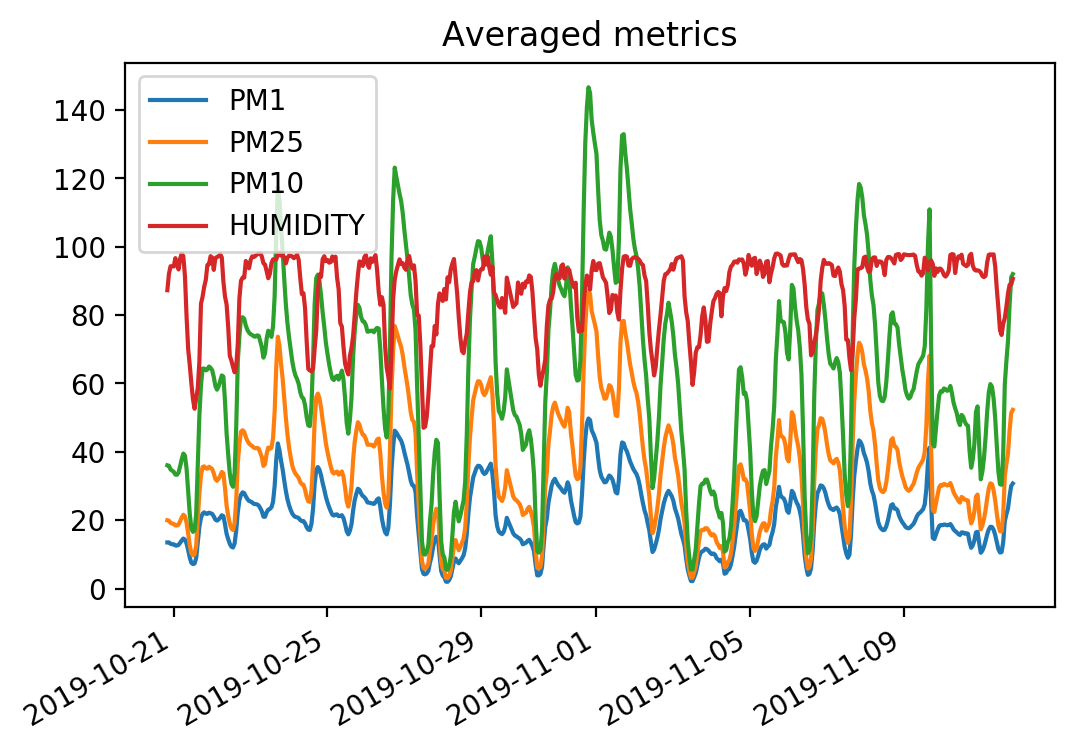

In [9]:
from functools import reduce

plt.rcParams['figure.dpi'] = 200

def plot_averaged_metrics(installations, metrics, start=None, end=None):
    values = {}
    for inst in installations.values():
        for (key, value) in sorted(inst['measurements'].items(), key=lambda k: k[0]):
            if set(metrics).issubset(set(map(lambda val: val['name'], value['values']))):
                if (start is None or start <= key) and (end is None or end >= key):
                    datetime_values = values.get(key, {})
                    for v in value['values']:
                        if v['name'] in metrics:
                            val_list = datetime_values.get(v['name'], [])
                            val_list.append(v['value']) 
                            datetime_values[v['name']] = val_list
                    values[key] = datetime_values

    series = {}
    datetimes = []
    for (time, metr) in values.items():
        datetimes.append(time)
        for (met_key, met_values) in metr.items():
            met_list = series.get(met_key, [])
            met_list.append(reduce(lambda a,b: a+b, met_values) / len(met_values))
            series[met_key] = met_list
    
    for (key, serie) in series.items():
        plt.plot(datetimes, serie, label=key)

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('Averaged metrics')
    plt.show()
    
plot_averaged_metrics(installations, ['PM1', 'PM10', 'PM25', 'HUMIDITY'])
    

# Correlation matrix

In [26]:
import pandas as pd

flattened_measurements = []
for (inst_id, inst) in installations.items():
    location = inst['location']
    is_krakow = location['is_krakow'] if location is not None else None
    elevation = location['elevation'] if location is not None else None
    if is_krakow is not None and elevation is not None:
        for (date, values) in inst['measurements'].items():
            wind_speed = None
            wind_deg = None
            weather = values['weather']
            is_day = values['is_day']
            if weather is not None:
                wind = weather['wind']
                if wind is not None:
                    wind_speed = wind['speed'] if 'speed' in wind else None
                    wind_deg = wind['deg'] if 'deg' in wind else None
            pm1 = None
            pm25 = None
            pm10 = None
            pressure = None
            humidity = None
            temperature = None
            for v in values['values']:
                if(v['name'] == 'PM1'):
                    pm1 = v['value']
                if(v['name'] == 'PM25'):
                    pm25 = v['value']
                if(v['name'] == 'PM10'):
                    pm10 = v['value']
                if(v['name'] == 'TEMPERATURE'):
                    temperature = v['value']
                if(v['name'] == 'HUMIDITY'):
                    humidity = v['value']
                if(v['name'] == 'PRESSURE'):
                    pressure = v['value']

            flattened_measurements.append({
                'month': date.month,
                'day': date.day,
                'weekday': date.weekday(),
                'hour': date.hour,
                'caqi': values['indexes'][0]['value'],
                'pm1': pm1,
                'pm25': pm25,
                'pm10': pm10,
                'temperature': temperature,
                'humidity': humidity,
                'pressure': pressure,
                'weekend': date.weekday() in [5, 6],
                'is_krakow': is_krakow,
                'elevation': elevation,
                'wind_deg': wind_deg,
                'wind_speed': wind_speed,
                'is_day': is_day
            })
    

df = pd.DataFrame(flattened_measurements)

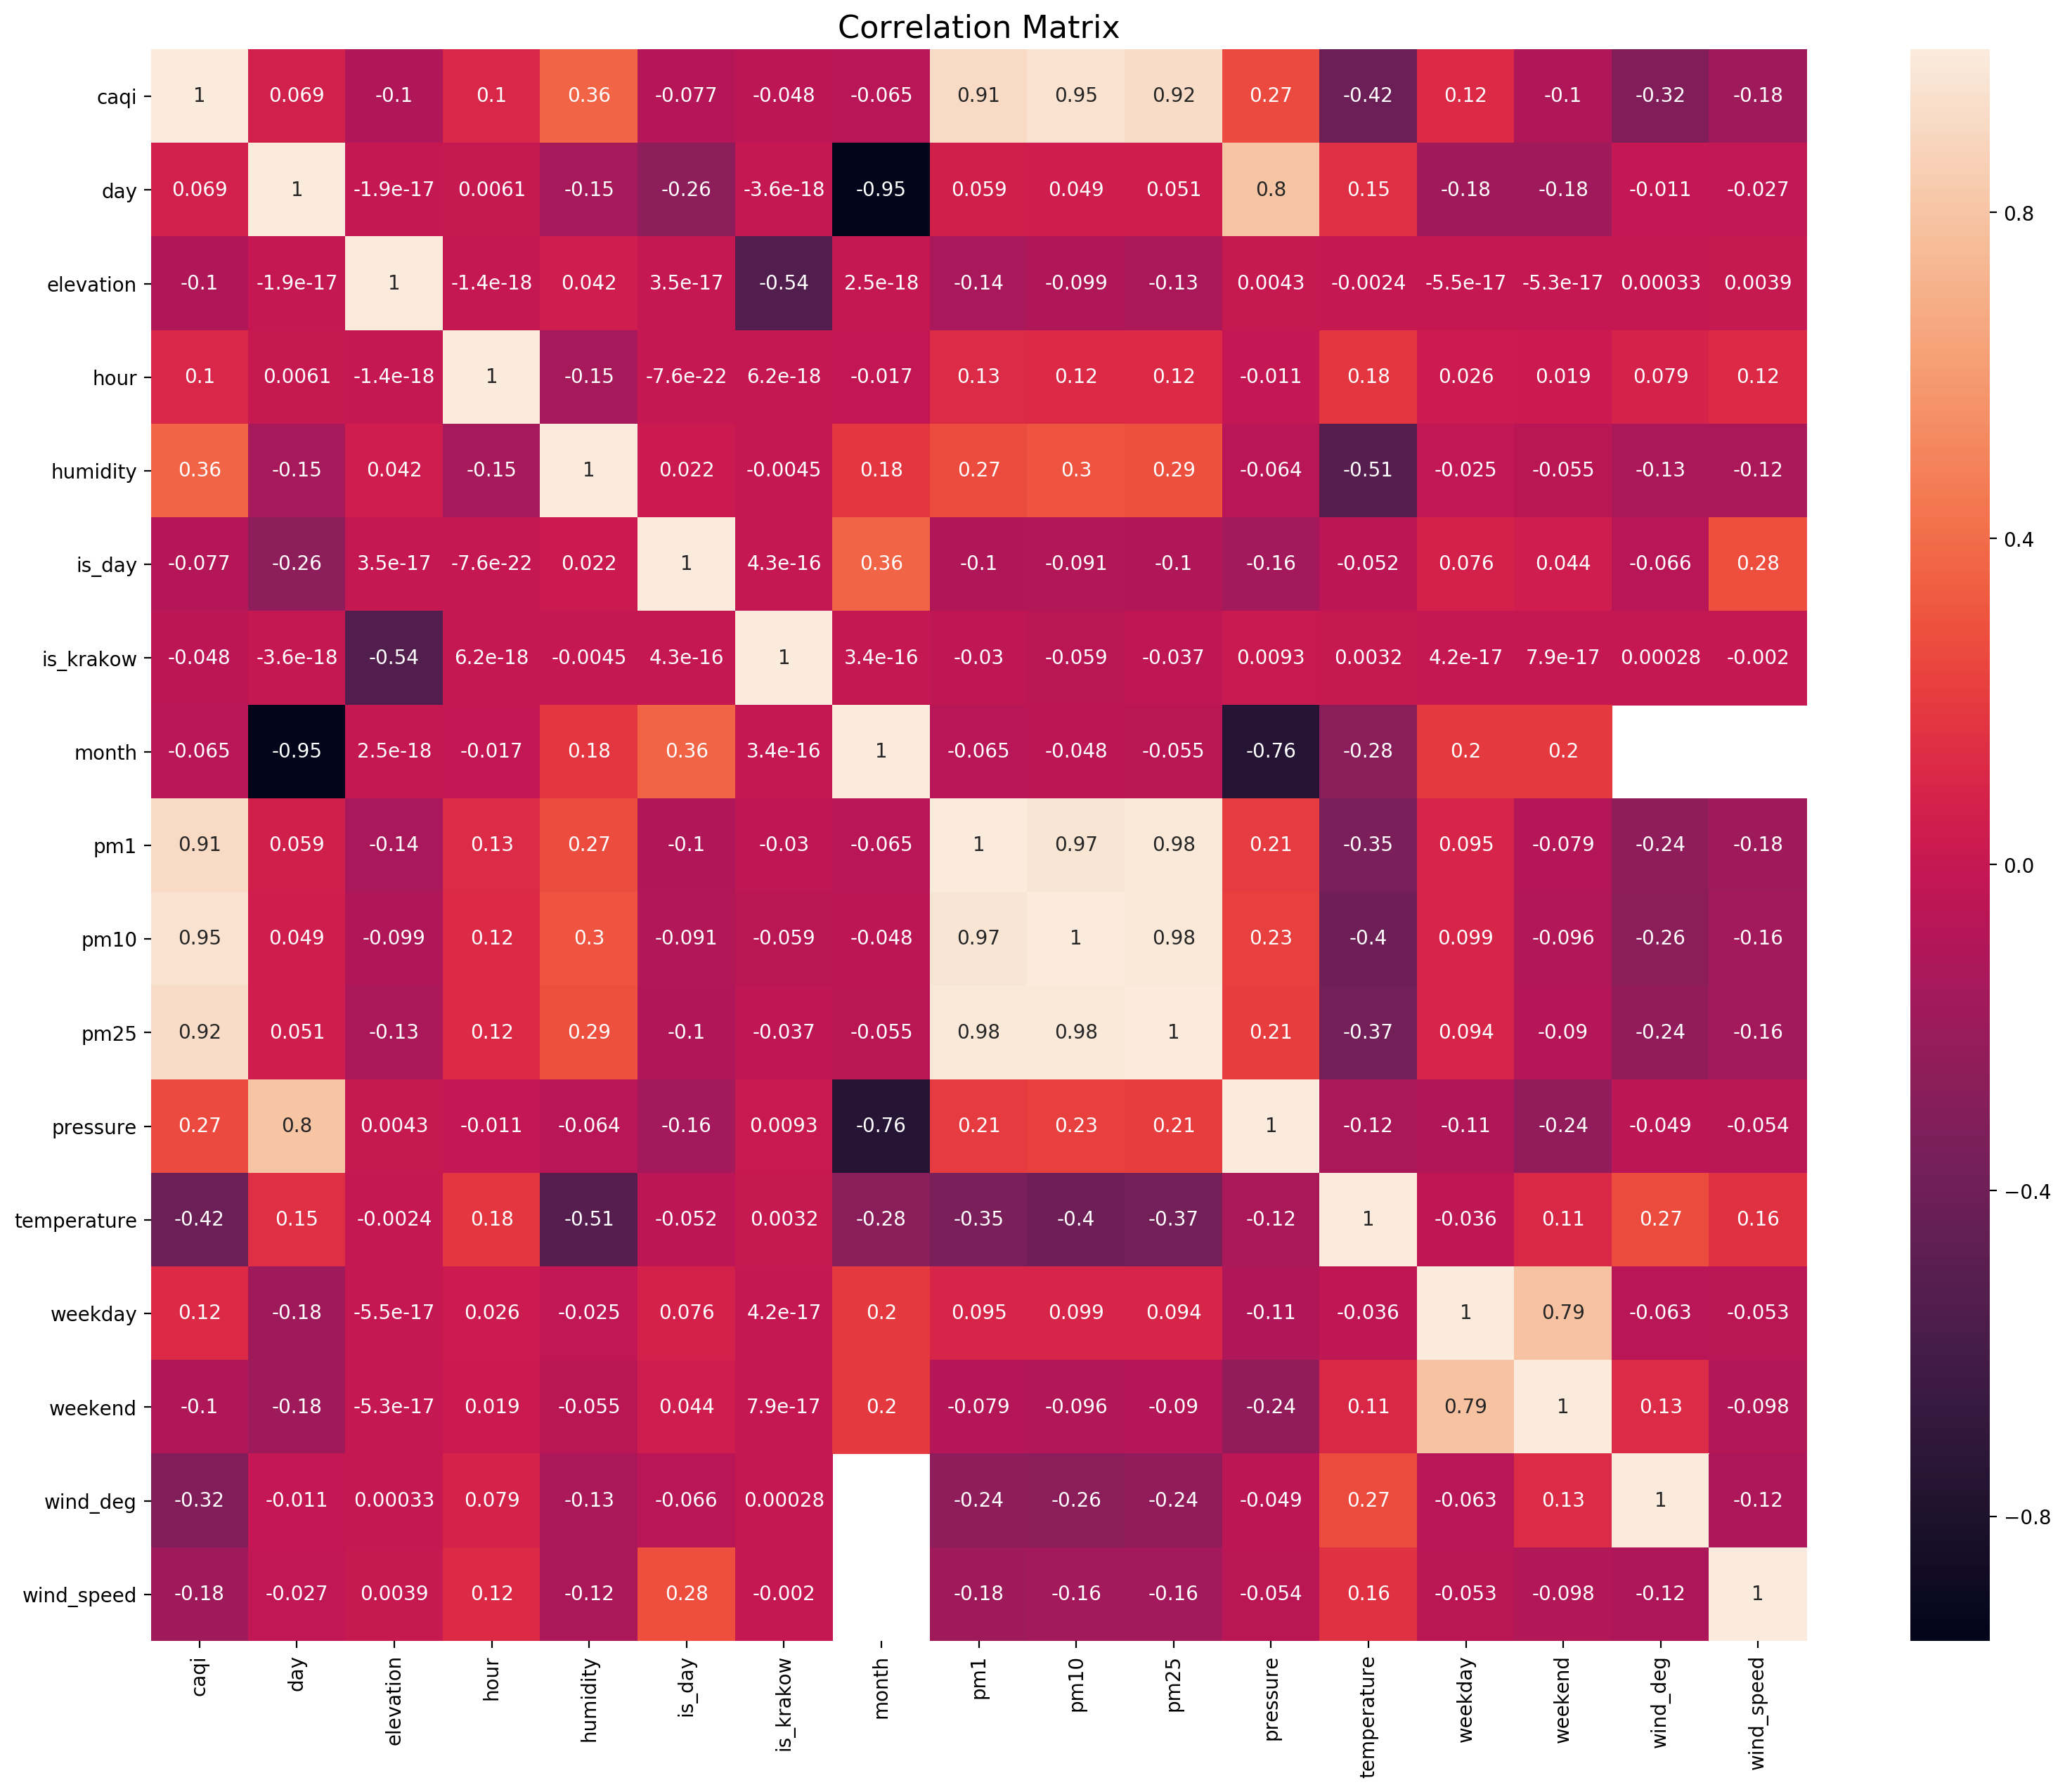

In [27]:
import seaborn as sns

plt.figure(figsize=(19, 15))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Matrix', fontsize=16);

# t-SNE

In [14]:
from sklearn.manifold import TSNE
X = df[['hour', 'caqi', 'temperature', 'humidity', 'pressure', 
        'weekend', 'is_krakow', 'elevation', 'wind_deg', 'wind_speed']].dropna()

X_no_label = X[['hour', 'caqi', 'temperature', 'humidity', 'pressure', 
        'weekend', 'elevation', 'wind_deg', 'wind_speed']]
X_embedded = TSNE(n_components=2, verbose=2, n_iter=300).fit_transform(X_no_label)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25587 samples in 0.014s...
[t-SNE] Computed neighbors for 25587 samples in 1.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25587
[t-SNE] Computed conditional probabilities for sample 2000 / 25587
[t-SNE] Computed conditional probabilities for sample 3000 / 25587
[t-SNE] Computed conditional probabilities for sample 4000 / 25587
[t-SNE] Computed conditional probabilities for sample 5000 / 25587
[t-SNE] Computed conditional probabilities for sample 6000 / 25587
[t-SNE] Computed conditional probabilities for sample 7000 / 25587
[t-SNE] Computed conditional probabilities for sample 8000 / 25587
[t-SNE] Computed conditional probabilities for sample 9000 / 25587
[t-SNE] Computed conditional probabilities for sample 10000 / 25587
[t-SNE] Computed conditional probabilities for sample 11000 / 25587
[t-SNE] Computed conditional probabilities for sample 12000 / 25587
[t-SNE] Computed conditional probabilities for sam

In [15]:
def plot_tsne_with_coloring(X, X_embedded, hue_label):
    plt.figure(figsize=(19,15))
    return sns.scatterplot(x='one', y='two', hue=hue_label, 
                           data=pd.DataFrame({'one': X_embedded[:,0], 'two': X_embedded[:,1], hue_label: X[hue_label]}))

## t-SNE with 'is_krakow' coloring

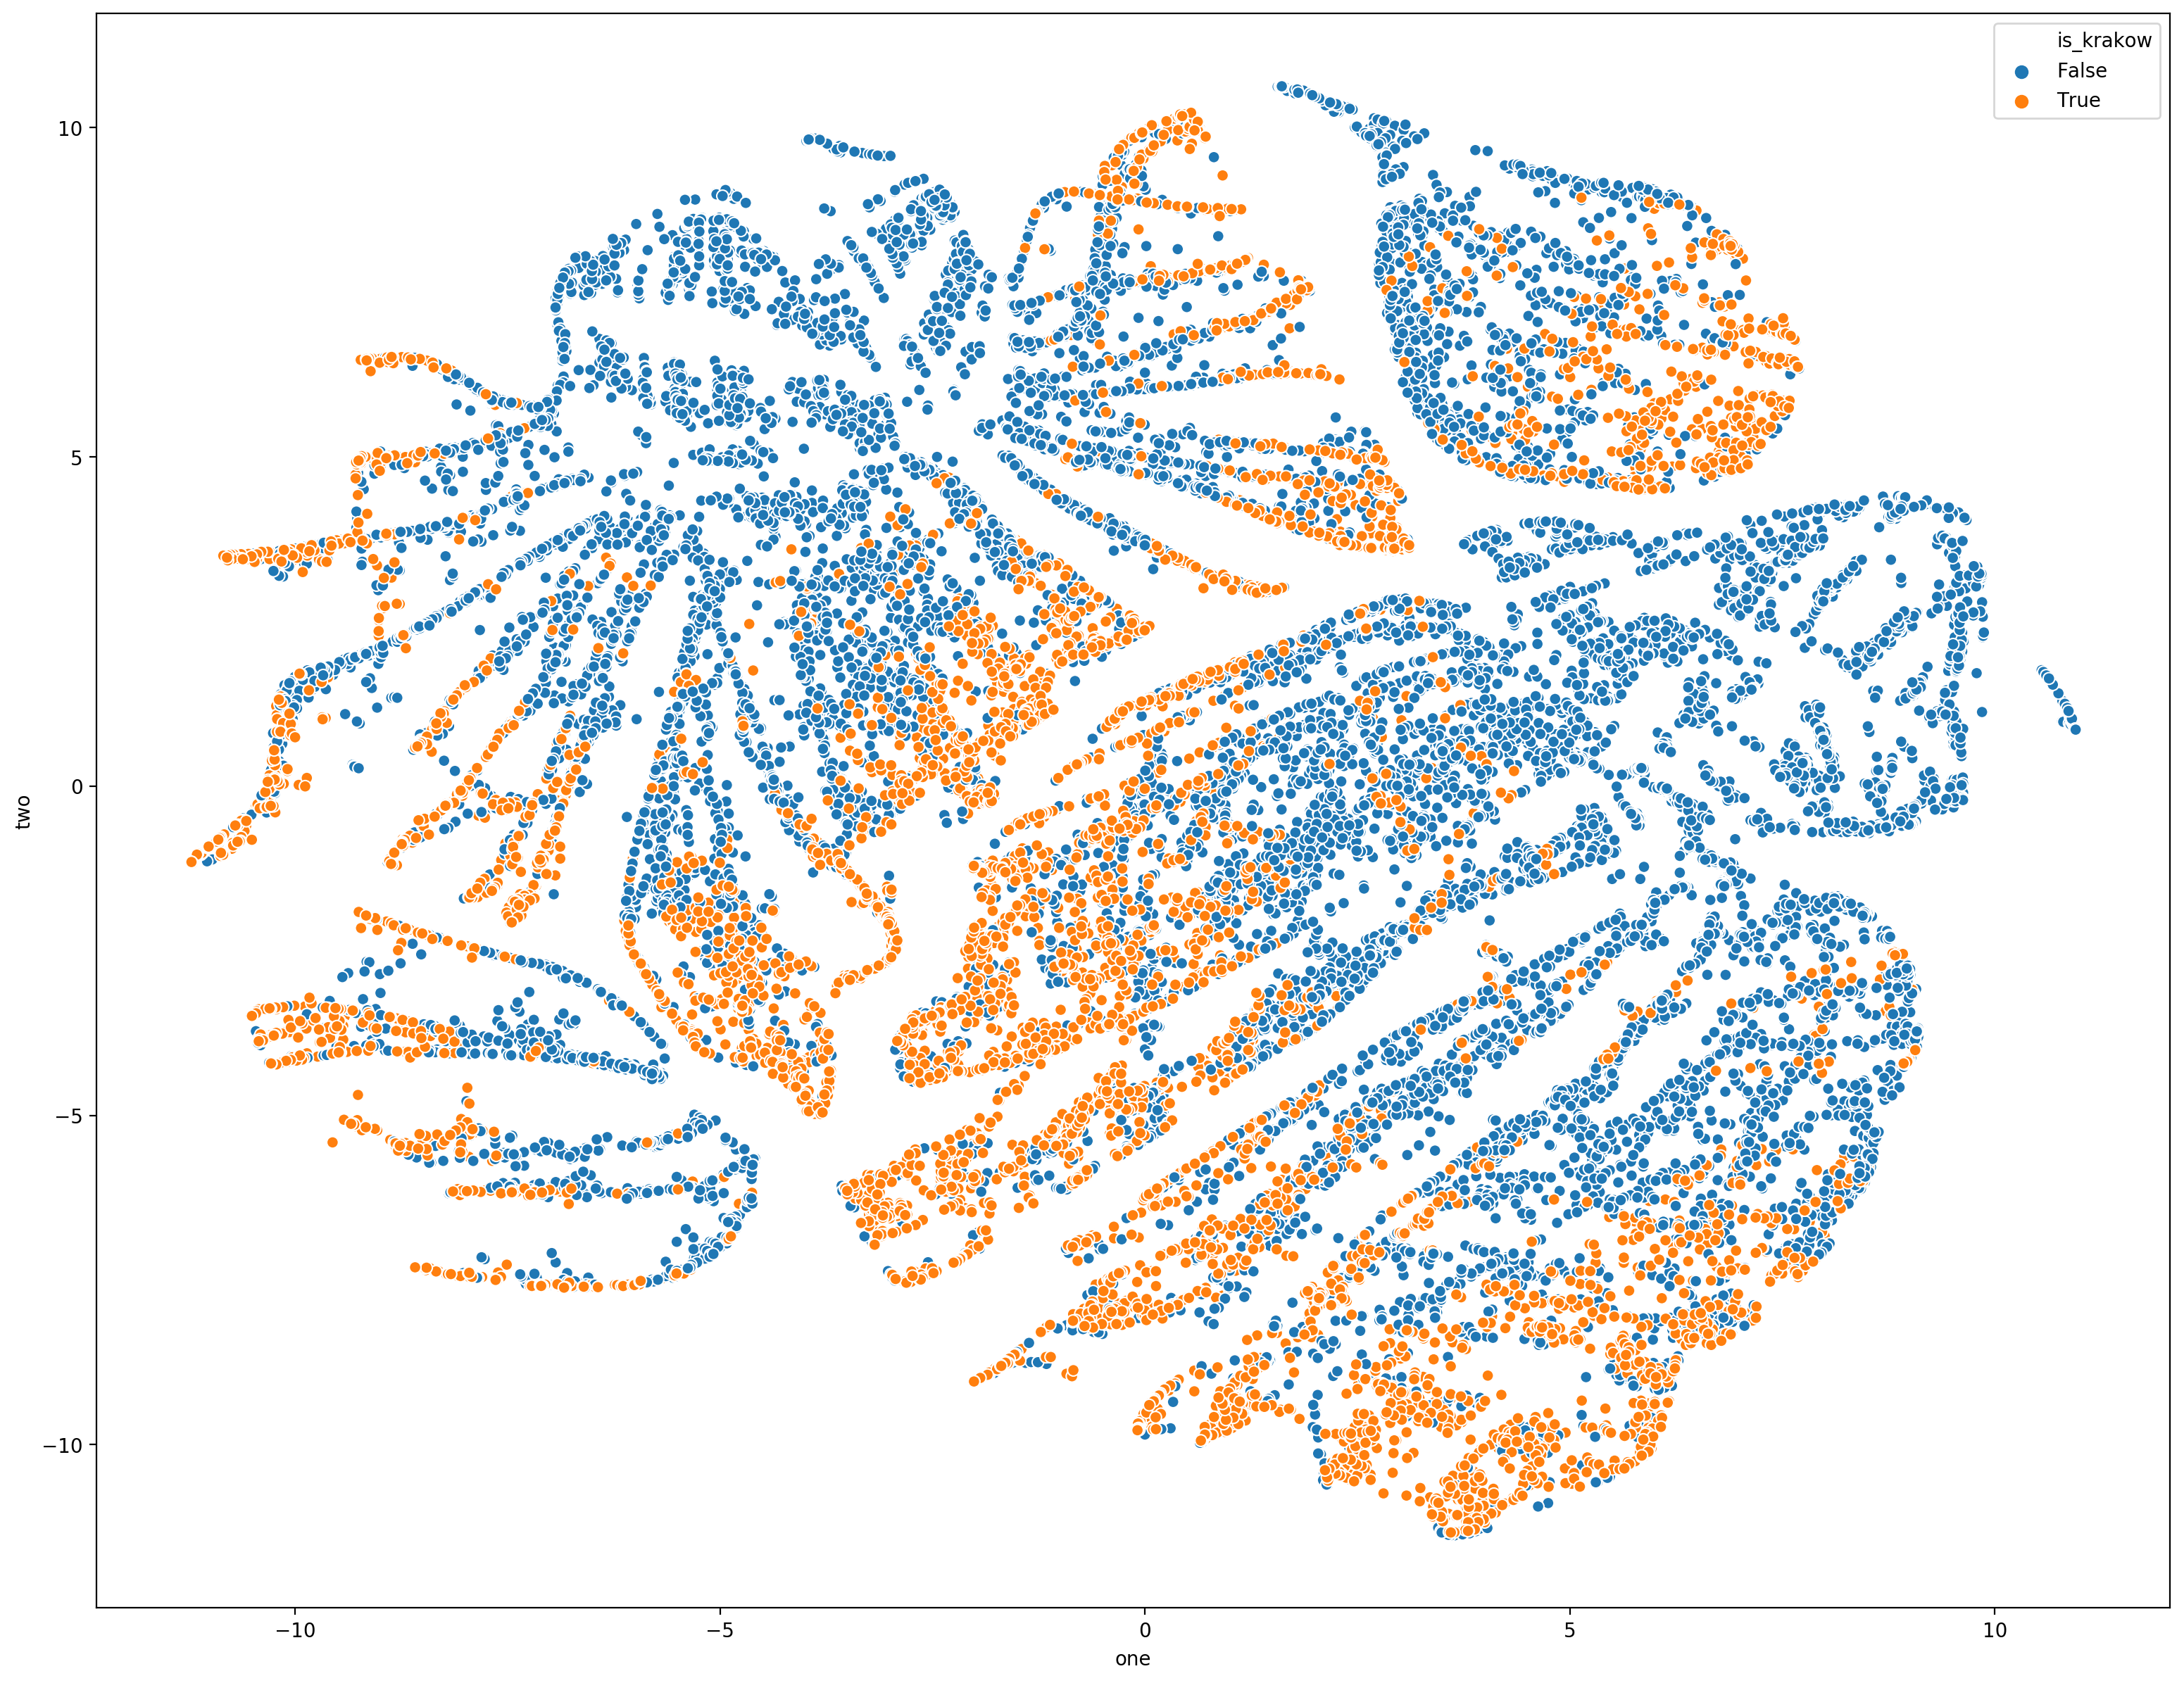

In [16]:
plot_tsne_with_coloring(X, X_embedded, 'is_krakow')

# Time series analysis

In [106]:
import numpy as np

def get_caqi_by_date(installations, installation_filter = lambda i: True):
    values = {}
    for inst in installations.values():
        if installation_filter(inst):
            for (key, value) in sorted(inst['measurements'].items(), key=lambda k: k[0]):
                datetime_values = values.get(key, [])
                for v in value['indexes']:
                    if v['name'] =='AIRLY_CAQI':
                        if v['value'] is not None:
                            datetime_values.append(v['value'])
                values[key] = datetime_values
    return values

def get_series(installations, splitter, true_label, false_label):
    true_values = get_caqi_by_date(installations, splitter)
    false_values = get_caqi_by_date(installations, lambda i: not splitter(i))

    series = {}
    datetimes = []
    true_items = list(true_values.items())
    false_items = list(false_values.items())
    for idx in range(0, len(true_items)):
        true_item = true_items[idx]
        datetimes.append(true_item[0])          
        true_list = series.get(true_label, [])
        true_list.append(reduce(lambda a,b: a+b, true_item[1]) / len(true_item[1]))
        series[true_label] = true_list
        
        false_item = false_items[idx]         
        false_list = series.get(false_label, [])
        false_list.append(reduce(lambda a,b: a+b, false_item[1]) / len(false_item[1]))
        series[false_label] = false_list
    return series, datetimes
            


def plot_caqi_index(series, datetimes):  
    colors = ['#f1a340', '#998ec3']
    series_items = list(series.items())
    for idx in range(0, len(series_items)):
        serie = series_items[idx][1]
        key = series_items[idx][0]
        plt.plot(datetimes, serie, label=key, color=colors[idx])
        first_timestamp = datetimes[0].timestamp()
        timestamps = list(map(lambda d: (d.timestamp()-first_timestamp) / 360000, datetimes))
        trend = np.polyfit(timestamps, serie, 1)
        p = np.poly1d(trend)
        print("Trend for {}: {}".format(key, p))
        plt.plot(datetimes, p(timestamps),"r--", color=colors[idx])

    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.title('CAQI Index')
    plt.show()
    

Trend for Kraków:  
-2.114 x + 56.67
Trend for outside Kraków:  
0.1516 x + 52.77


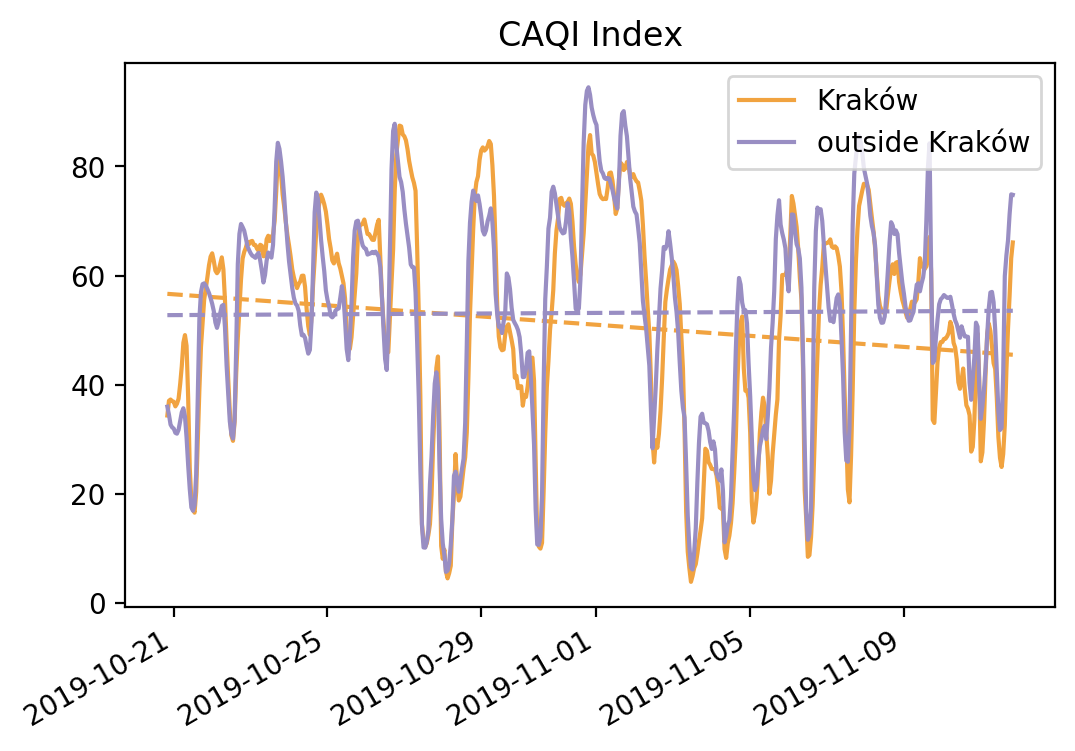

In [108]:
series, datetimes = get_series(installations, lambda i: i['location'] is not None 
                               and i['location']['is_krakow'], 'Kraków', 'outside Kraków')
plot_caqi_index(series, datetimes)


## Timeseries  seasonal decompsition

In [105]:
%pip install statsmodels

     |████████████████████████████████| 10.4MB 3.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [131]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

inside_serie = Series(series['Kraków'], index=datetimes)
outside_serie = Series(series['outside Kraków'], index=datetimes)

def decompose(serie, model):
    return seasonal_decompose(serie, model=model, freq=24)
    

In [148]:
inside_res = decompose(inside_serie, 'additive')
outside_res = decompose(outside_serie, 'additive')

def plot_component(inside_component, outside_component, title):
    ax = plt.gca()
    inside_component.plot(kind='line', ax=ax, title=title)
    outside_component.plot(kind='line', ax=ax, title=title)
    plt.legend(['Inside Kraków','Outside Kraków'])
    plt.show()

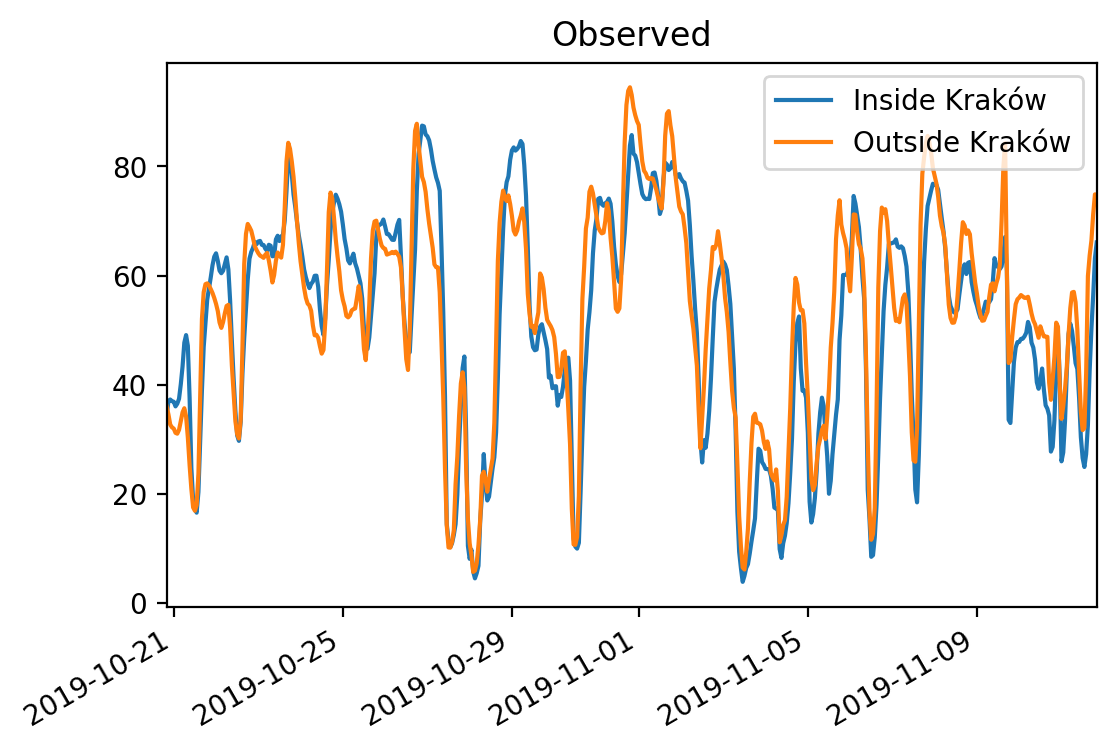

In [149]:
plot_component(inside_res.observed, outside_res.observed, 'Observed')

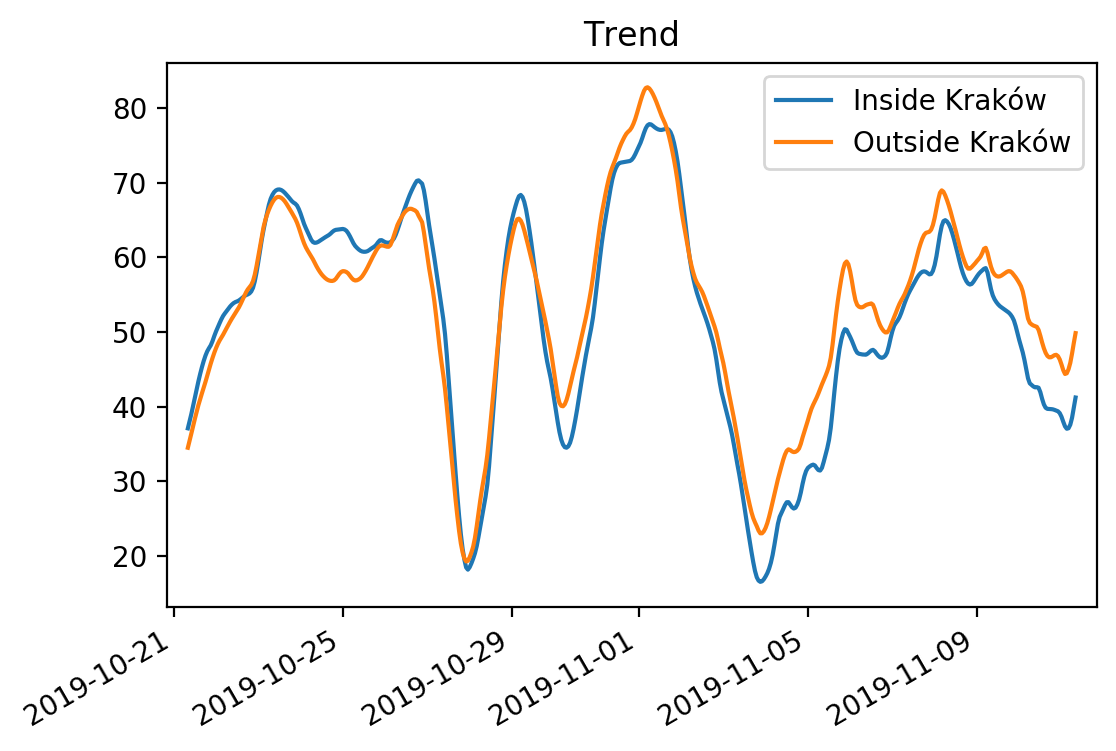

In [150]:
plot_component(inside_res.trend, outside_res.trend, 'Trend')

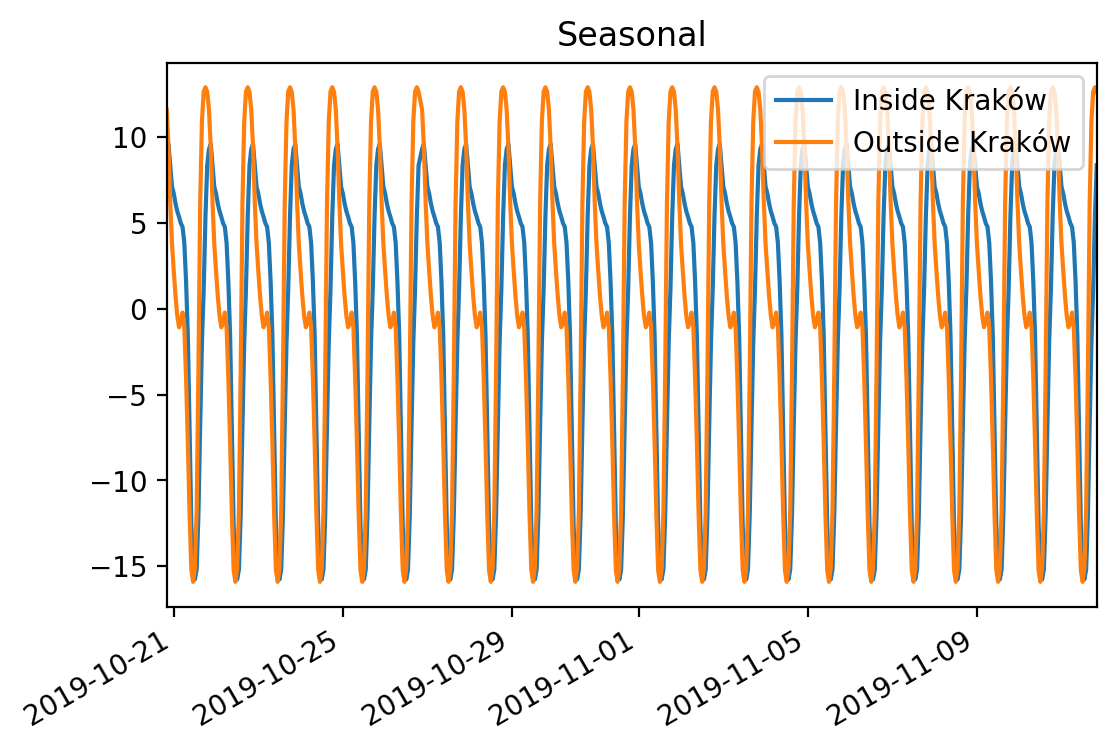

In [153]:
plot_component(inside_res.seasonal, outside_res.seasonal, 'Seasonal')

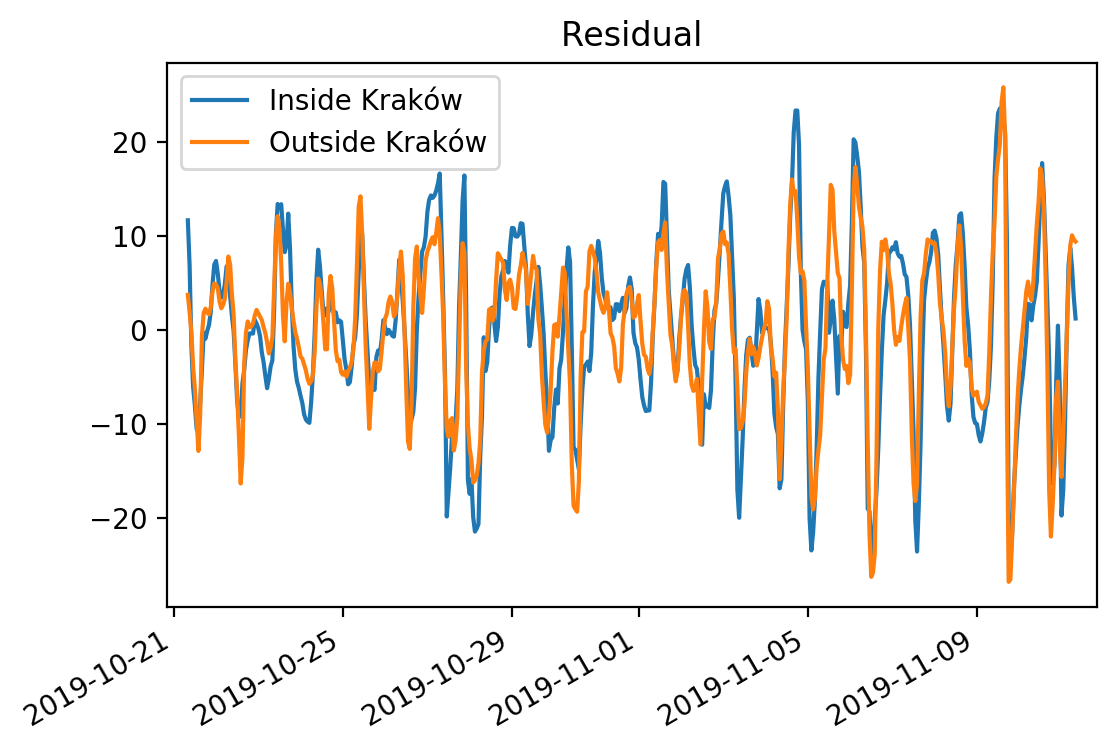

In [155]:
plot_component(inside_res.resid, outside_res.resid, 'Residual')

# Statistics inside & outside Kraków

In [71]:
import functools

inside_krakow_by_date = get_caqi_by_date(installations, lambda i: i['location'] is not None and i['location']['is_krakow'])
outside_krakow_by_date = get_caqi_by_date(installations, lambda i: i['location'] is not None and not i['location']['is_krakow'])
inside_arr = np.asarray(reduce(list.__add__, inside_krakow_by_date.values()))
outside_arr = np.asarray(reduce(list.__add__, outside_krakow_by_date.values())) 

## Average CAQI

In [78]:
avg_inside = np.mean(inside_arr)
std_dev_inside = np.std(inside_arr)
avg_outside = np.mean(outside_arr)
std_dev_outside = np.std(outside_arr)

print("Average CAQI inside Kraków: {}±{}".format(round(avg_inside, 2), round(std_dev_inside, 2)))
print("Average CAQI outside Kraków: {}±{}".format(round(avg_outside, 2), round(std_dev_outside, 2)))

Average CAQI inside Kraków: 50.96±22.56
Average CAQI outside Kraków: 53.21±23.27


## Longest time serie with CAQI > 50

In [86]:
def get_longest_timeserie(installation):
    measurements = sorted(inst['measurements'].items(), key=lambda k: k[0])
    longest = 1
    current_longest = 0
    for (date, measurement) in measurements:
        indexes = measurement['indexes']
        for v in measurement['indexes']:
                    if v['name'] =='AIRLY_CAQI':
                        if v['value'] is not None and v['value'] > 50:
                            current_longest = current_longest + 1
                            if current_longest > longest:
                                longest = current_longest
                        else:
                            current_longest = 0
    return longest 

def get_longest_timeseries(installations):
    longest_inside = 0
    longest_outside = 0
    for (inst_id, inst) in installations.items():
        if inst['location'] is not None:
            if inst['location']['is_krakow']:
                ins_longest = get_longest_timeserie(inst)
                if ins_longest > longest_inside:
                    longest_inside = ins_longest
            else:
                out_longest = get_longest_timeserie(inst)
                if out_longest > longest_outside:
                    longest_outside = out_longest
    return longest_inside, longest_outside
            
inside, outside = get_longest_timeseries(installations)
print("Longest CAQI > 50 inside Kraków: {}h".format(inside))
print("Longest CAQI > 50 outside Kraków: {}h".format(outside))

Longest CAQI > 50 inside Kraków: 14h
Longest CAQI > 50 outside Kraków: 14h
